# Exploratory Data Analysis
author: Jinseok Moon  
date: 2022-11-20

In [1]:
from pycocotools.coco import COCO

In [2]:
import glob

In [46]:
pth = './../data/train'

In [43]:
_trainpath = pth + '/*.json'

In [12]:
data_path = './../data/train/*/data.json'

In [47]:
glob.glob(pth + '/*/*.json')

['./../data/train/batch_06/data.json',
 './../data/train/batch_01/data.json',
 './../data/train/batch_02/data.json',
 './../data/train/batch_05/data.json',
 './../data/train/batch_04/data.json',
 './../data/train/batch_03/data.json']

In [49]:
len(coco[0].imgs.keys())

500

In [16]:
coco = [COCO(_data) for _data in datalist]

loading annotations into memory...
Done (t=1.37s)
creating index...
index created!
loading annotations into memory...
Done (t=1.61s)
creating index...
index created!
loading annotations into memory...
Done (t=1.16s)
creating index...
index created!
loading annotations into memory...
Done (t=1.12s)
creating index...
index created!
loading annotations into memory...
Done (t=1.28s)
creating index...
index created!
loading annotations into memory...
Done (t=1.20s)
creating index...
index created!


In [52]:
path

'batch_06/0005.jpg'

In [51]:
path = coco[0].loadImgs(img_id)[0]['file_name']

In [28]:
import numpy as np

In [29]:
ann_ids = coco[0].getAnnIds(imgIds=img_id)
target = coco[0].loadAnns(ann_ids)

bboxes = []
for ann in target:
    bbox = np.array(ann['bbox'])
    bboxes.append(bbox)
bboxes = np.array(bboxes)

In [1]:
import json
from PIL import Image
import os
import glob 
import matplotlib.pyplot as plt
import bokeh
import numpy as np
import pandas as pd
import seaborn as sns
import random
import cv2
import bbox_visualizer as bbv

ModuleNotFoundError: No module named 'bokeh'

## 학습 데이터 검색하기
Missing value가 있는지, 데이터의 분포는 어떤지를 확인합니다.
bbox가 list의 형태를 띄고 있어서 정확한 분석이 어렵기 때문에 bbox의 각 element별로 column을 갖도록 쪼개주고, 원래의 bbox 열은 샘플 이미지 plot을 위해 따로 남겨둡니다.

In [2]:
# 데이터 불러오기
images_path = sorted(glob.glob('./../dataset/train/*'))
json_path = './dataset/train.json'
with open(json_path, 'r') as f:
    data_json = json.load(f)

annots = ['image_id', 'category_id', 'area', 'bbox', 'iscrowd', 'id']
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

# to dataframe
df = pd.DataFrame(data_json['annotations'], columns=annots)

# bbox split
split_bbox = pd.DataFrame(df['bbox'].to_list(), columns = ['bbox_xmin', 'bbox_ymin', 'bbox_width', 'bbox_height'])
df = pd.concat([df, split_bbox], axis=1)
df_bbox = df.pop('bbox')

In [3]:
# bbox를 포함해서 모든 데이터의 분포 보기
df.describe(include='all')

,image_id,category_id,area,iscrowd,id,bbox_xmin,bbox_ymin,bbox_width,bbox_height
count,23144.000000,23144.000000,2.314400e+04,23144.0,23144.000000,23144.000000,23144.000000,23144.000000,23144.000000
mean,2439.377333,3.409307,9.286396e+04,0.0,11571.500000,386.195653,382.230008,257.499170,252.241518
std,1410.659303,2.834300,1.359791e+05,0.0,6681.241651,244.491114,217.282849,204.582362,200.143898
min,0.000000,0.000000,5.600000e-01,0.0,0.000000,0.000000,0.000000,0.700000,0.800000
25%,1206.000000,1.000000,9.997670e+03,0.0,5785.750000,200.100000,226.975000,99.750000,93.500000
50%,2453.500000,3.000000,3.893847e+04,0.0,11571.500000,362.700000,370.500000,200.900000,196.100000
75%,3678.000000,7.000000,1.191225e+05,0.0,17357.250000,553.325000,524.900000,357.650000,359.825000
max,4882.000000,9.000000,1.048371e+06,0.0,23143.000000,1015.400000,1011.500000,1023.900000,1023.900000


In [4]:
# missing value check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23144 entries, 0 to 23143
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image_id     23144 non-null  int64  
 1   category_id  23144 non-null  int64  
 2   area         23144 non-null  float64
 3   iscrowd      23144 non-null  int64  
 4   id           23144 non-null  int64  
 5   bbox_xmin    23144 non-null  float64
 6   bbox_ymin    23144 non-null  float64
 7   bbox_width   23144 non-null  float64
 8   bbox_height  23144 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 1.6 MB


Missing value가 없고, 값이 모두 제대로 들어있음을 확인했습니다. 이제 분석에 불필요한 정보를 지워줍니다. 모든 값이 0으로, 이번 task에서는 사용되지 않는 `iscrowd` 정보를 지워줍니다. 또한 box의 위치보다는 크기가 더 중요하므로, `bbox_xmin`, `bbox_ymin` 정보를 지워줍니다.

In [5]:
df = df.drop('iscrowd', axis=1)
df = df.drop('bbox_xmin', axis=1)
df = df.drop('bbox_ymin', axis=1)

# numerical category id to category string
df['category_object'] = df['category_id'].map(pd.DataFrame(classes, columns=['category'])['category'])

각 카테고리별로 데이터가 몇 개씩 있는지 확인해봅니다. 가장 많은 것은 `Paper`로 6352개, 가장 적은 것은 `Battery`로 159개입니다.

In [6]:
# Data에 관련된 부분을 `pandas_profiling` 라이브러리를 통해서도 EDA가 가능합니다.
import pandas_profiling
pr=df.profile_report()
pr.to_file(output_file='./pr_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Bokeh & Pandas 를 이용한 데이터 가시화
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')
# Create Bokeh-Table with DataFrame:
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.models import ColumnDataSource

Loading BokehJS ...

In [8]:
# 각 카테고리별 개수
df['category_object'].value_counts().plot_bokeh(
    kind='barh', 
    figsize=(480,480),
    xlabel='counts',
    zooming=False,
    panning=False,
    legend=False,
    fontsize_ticks=10
    )

Figure(id='1039', ...)

## 실제 데이터 살펴보기
실제 데이터의 bounding box가 어떤식으로 되어있는지 살펴봅니다.

In [9]:
def show_sample(idx):
    img = images_path[idx]
    labels = []
    bboxes = []
    for label, box in zip(df[df['image_id']==idx]["category_object"], df_bbox[df['image_id']==idx]):
        labels.append(label)
        bboxes.append([int(box[0]), int(box[1]), int(box[0]+box[2]), int(box[1]+box[3])])

    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_with_boxes = bbv.draw_multiple_rectangles(img, bboxes)
    img_with_boxes_2 = img_with_boxes.copy()
    img_with_boxes = bbv.add_multiple_labels(img_with_boxes, labels, bboxes)
    img_with_T_labels = bbv.add_multiple_T_labels(img_with_boxes_2, labels, bboxes)

    img_with_flags = bbv.draw_multiple_flags_with_labels(img, labels, bboxes)
    fig, ax = plt.subplots(1, figsize=(6.4, 6.4), dpi=100)
    ax.imshow(img_with_boxes)
    ax.set_xticks([])
    ax.set_yticks([])

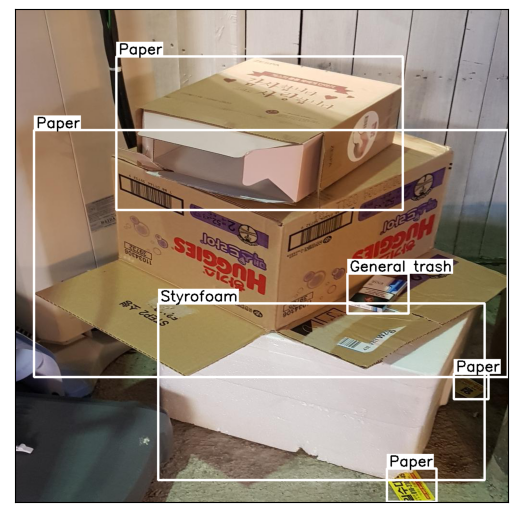

In [10]:
show_sample(idx=2000)

## Bounding Box Analysis
Bounding Box 크기를 히스토그램으로 나타내면 다음과 같습니다. `width`, `height`, `area` 로 나타냈습니다.

In [11]:
# 각 카테고리별 개수
p_width = df['bbox_width'].plot_bokeh(
    kind='hist', 
    bins=np.linspace(0, 1000, 20),
    zooming=False,
    panning=False,
    legend=False,
    ylabel='counts',
    vertical_xlabel=True,
    show_figure=False
    )

p_height = df['bbox_height'].plot_bokeh(
    kind='hist', 
    bins=np.linspace(0, 1000, 20),
    zooming=False,
    panning=False,
    legend=False,
    ylabel='counts',
    vertical_xlabel=True,
    show_figure=False
    )

pandas_bokeh.plot_grid([[p_width, p_height]],
                       width=480)

Column(id='1288', ...)

In [12]:
df['area'].plot_bokeh(
    bins=np.linspace(0, 10000, 30),
    kind='hist', 
    legend=False,
    zooming=False,
    vertical_xlabel=True,
    ylabel='counts',
    )

Figure(id='1407', ...)

## 참고용
클래스별 불균형이 크기 때문에, 보다 정확한 판단을 위해서는 Data augmentation이 필요합니다.
mmdetection의 train_pipeline을 건드려서 multi-scale 학습 혹은 data wrapper 클래스 ClassImbalancedDataset, RepeatDataSet 등을 사용해보겠습니다.
https://mmdetection.readthedocs.io/en/latest/_modules/mmdet/datasets/dataset_wrappers.html